# RAG Series - Module 1: Different Search Methods

### 🤔 What is RAG?
**Retrieval-Augmented Generation (RAG)** allows AI to access and use your specific data in real-time. Instead of relying only on training data, RAG:

1. **Searches** through your documents/data
2. **Retrieves** the most relevant information  
3. **Generates** accurate answers based on that information

**Result**: Your AI + Your Data = More Accurate, Up-to-date Responses

### 📚 Search Types We'll Explore

1. **🔍 Keyword Search**: Finds documents with exact word matches
2. **🧠 Semantic Search**: Understands meaning and context
3. **🏷️ Metadata Filtering**: Searches within specific document categories
4. **⚡ Hybrid Search**: Combines multiple approaches for optimal results

### 🛠️ Tools We'll Use
- **LangChain**: Framework for building AI applications
- **Pinecone**: Vector database for storing and searching embeddings
- **OpenAI**: For generating embeddings and understanding text

Let's dive in! 🏊‍♂️

# 🛠️ Setup: Installation

## Step 1: Install Required Libraries

We need these Python packages:

- **`langchain`**: Main framework for building RAG applications
- **`langchain-pinecone`**: Connects LangChain with Pinecone
- **`langchain-openai`**: Integrates OpenAI's embedding models
- **`langchain-community`**: Additional community tools
- **`pinecone`**: Vector database for storing embeddings

Run the cell below to install everything:

In [ ]:
# Install all required packages
pip install -qU langchain langchain-pinecone langchain-openai langchain-community pinecone

# 🔐 Step 2: API Keys Setup

## How to Get Your Keys:

**OpenAI API Key:**
1. Visit [OpenAI Platform](https://platform.openai.com/account/api-keys)
2. Sign up/Login → Create new secret key
3. Copy the key (starts with `sk-`)

**Pinecone API Key:**
1. Visit [Pinecone Console](https://app.pinecone.io)
2. Sign up for free account → Go to "API Keys"
3. Copy your API key

In [ ]:
# Replace with your actual API keys
OPENAI_API_KEY = "your-openai-api-key-here"      # Starts with sk-
PINECONE_API_KEY = "your-pinecone-api-key-here"  # Starts with pcsk_

# Set as environment variables for automatic library access
import os
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
os.environ["PINECONE_API_KEY"] = PINECONE_API_KEY

print("✅ API keys configured!")
print("🔍 OpenAI key starts with:", OPENAI_API_KEY[:5] + "..." if len(OPENAI_API_KEY) > 5 else "Please set your key")
print("🌲 Pinecone key starts with:", PINECONE_API_KEY[:5] + "..." if len(PINECONE_API_KEY) > 5 else "Please set your key")

# 📚 Step 3: Load and Prepare Our Dataset

Before we can search through information, we need some information to search! I prepared a special dataset just for learning RAG concepts.

## 🎯 About Our Learning Dataset

I prepared **100 educational documents** as `LangChain Document` objects for learning RAG concepts.

### 📖 Document Structure:

**Content (`page_content`)**: 
- Informative paragraphs about AI, ML, RAG, LangChain, and Pinecone
- Covers different difficulty levels and topics

**Metadata (Additional Info)**:
- `doc_id`: Unique identifier (doc_1, doc_2, etc.)
- `topic`: Main subject of the document
- `category`: Content type (retrieval, langchain, pinecone, etc.)
- `difficulty`: Skill level (beginner, intermediate, advanced)
- `source`: Origin (ai_generated for our dataset)
- `tokens`: Approximate word count
- `created_at`: Creation timestamp

This metadata helps us understand how different search methods work and what types of content they find.

In [ ]:
# Load required libraries
import joblib
import requests
from langchain.schema import Document

# Google Drive file configuration
DRIVE_FILE_ID = "13hqOdyB93Xi2Qsm6fJVLILBSb-SYSHvk"
DRIVE_URL = f"https://drive.google.com/uc?id={DRIVE_FILE_ID}&export=download"
LOCAL_FILE = "chuck_docs_as_dicts.joblib"

# Download dataset from Google Drive
def download_from_drive(url, filename):
    """Download file from Google Drive"""
    response = requests.get(url)
    response.raise_for_status()
    
    with open(filename, 'wb') as f:
        f.write(response.content)
    
    return filename

# Download and load dataset
try:
    print("📥 Downloading dataset from Google Drive...")
    download_from_drive(DRIVE_URL, LOCAL_FILE)
    data = joblib.load(LOCAL_FILE)
    print(f"✅ Loaded {len(data)} documents")
except Exception as e:
    print(f"❌ Error loading dataset: {str(e)}")
    raise

# Convert to LangChain Document objects
docs = []
for item in data:
    doc = Document(
        page_content=item["page_content"],  # The actual text
        metadata=item["metadata"]           # Additional information
    )
    docs.append(doc)

print(f"📚 Converted to {len(docs)} LangChain Document objects")

In [ ]:
# Load required libraries
import joblib
from langchain.schema import Document

# Load pre-prepared dataset from the data directory
try:
    data = joblib.load("../data/data.joblib")
    print(f"✅ Loaded {len(data)} documents")
except FileNotFoundError:
    print("❌ File not found. Make sure data.joblib is in the data/ directory.")

# Convert to LangChain Document objects
docs = []
for item in data:
    doc = Document(
        page_content=item["page_content"],  # The actual text
        metadata=item["metadata"]           # Additional information
    )
    docs.append(doc)

✅ Loaded 100 documents


# 🔍 Part 1: Keyword Search (Sparse Search)

### 🎯 What is Keyword Search?

**Keyword Search** finds documents containing exact word matches - like using Ctrl+F in a document.

### 🔍 How It Works:
1. **Tokenization**: Breaks text into individual words
2. **Exact Matching**: Finds documents with your search terms
3. **Frequency Scoring**: Ranks by how often terms appear

### ✅ Best For:
- Specific terms or technical jargon
- Exact phrases or product names
- When you know precise words in documents

### ❌ Limitations:
- Misses synonyms ("car" won't find "automobile")
- No context understanding
- Struggles with different phrasings

### 🏗️ Implementation:
We'll use **Pinecone's sparse vectors** with their English sparse embedding model.

🔗 **Learn More**: [Pinecone Sparse Search Guide](https://www.pinecone.io/learn/learn-pinecone-sparse/)

In [ ]:
# Setup Pinecone for keyword search
from pinecone import Pinecone

# Initialize Pinecone client
pc = Pinecone(api_key=PINECONE_API_KEY)
sparse_index_name = "sparse-for-hybrid-py"

# Create sparse index if it doesn't exist
if not pc.has_index(sparse_index_name):
    pc.create_index_for_model(
        name=sparse_index_name,
        cloud="aws",
        region="us-east-1",
        embed={
            "model": "pinecone-sparse-english-v0",    # Sparse embedding model
            "field_map": {"text": "chunk_text"}       # Field mapping
        }
    )
    print(f"✅ Created sparse index: {sparse_index_name}")
else:
    print(f"✅ Using existing sparse index: {sparse_index_name}")

# Connect to index
index = pc.Index(sparse_index_name)

In [ ]:
# Implement keyword search with sparse vectors
from langchain_pinecone import PineconeSparseEmbeddings
from langchain_pinecone.vectorstores_sparse import PineconeSparseVectorStore
from uuid import uuid4

# Initialize sparse embedding model
sparse_embeddings = PineconeSparseEmbeddings(model="pinecone-sparse-english-v0")

# Create sparse vector store
vector_store = PineconeSparseVectorStore(
    index=index,
    embedding=sparse_embeddings
)

# Generate unique IDs and add documents
uuids = [str(uuid4()) for _ in range(len(docs))]
vector_store.add_documents(documents=docs, ids=uuids)

# Test keyword search
search_query = "machine learning"
results = vector_store.similarity_search(search_query, k=2)

print(f"🔍 Keyword search for: '{search_query}'")
print(f"📊 Found {len(results)} results:")

for i, doc in enumerate(results, start=1):
    print(f"\nResult {i}:")
    print(f"Content: {doc.page_content[:120]}...")
    print(f"Category: {doc.metadata.get('category', 'N/A')}")
    print(f"Topic: {doc.metadata.get('topic', 'N/A')}")

--- Result 1 ---
Content: It allows systems to balance the precision of semantic search with the coverage of lexical matching. Tools like LangChain and Pinecone simplify the implementation, allowing for powerful, scalable pipelines. How LangChain Integrates with Pinecone is a critical concept when designing advanced search and retrieval systems.
Metadata: {'category': 'langchain', 'created_at': '2025-03-28', 'difficulty': 'intermediate', 'doc_id': 'doc_2', 'source': 'ai_generated', 'tokens': 85.0, 'topic': 'How LangChain Integrates with Pinecone'}

--- Result 2 ---
Content: This technique is especially useful in domains like legal, healthcare, and customer support where accuracy matters. Choosing Distance Metrics in Pinecone is a critical concept when designing advanced search and retrieval systems. Tools like LangChain and Pinecone simplify the implementation, allowing for powerful, scalable pipelines.
Metadata: {'category': 'retrieval', 'created_at': '2024-09-28', 'difficulty': 'begi

# 🧠 Part 2: Semantic Search (Dense Search)

## The "Smart" Search: Understanding Meaning and Context

## 🎯 What is Semantic Search?

**Semantic Search** understands meaning and context, not just exact words. It's like having an intelligent librarian who knows what you really mean.

### 🧠 How It Works:
1. **Neural Embeddings**: Converts text into vectors that capture meaning
2. **Contextual Understanding**: Knows "car" and "automobile" are similar
3. **Similarity Matching**: Finds documents with similar meanings

### ✅ Best For:
- Conceptual queries ("How do I improve model performance?")
- Synonym handling (searching "AI" finds "machine learning")
- Natural language questions
- Context understanding

### ❌ Limitations:
- May miss exact technical terms
- Can be "too smart" and return irrelevant results
- Less predictable than keyword search

### 🏗️ Implementation:
We'll use **OpenAI's text-embedding-3-small** to create **1536-dimensional vectors** that capture semantic meaning.

🔗 **Learn More**: [Pinecone Vector Search Guide](https://www.pinecone.io/learn/search-with-pinecone/)

In [ ]:
# Setup Pinecone for semantic search
from pinecone import Pinecone, ServerlessSpec

pc = Pinecone(api_key=PINECONE_API_KEY)
dense_index_name = "dense-for-hybrid-py"

# Create dense index if needed
if not pc.has_index(dense_index_name):
    pc.create_index(
        name=dense_index_name,
        dimension=1536,                              # OpenAI embedding dimension
        metric="cosine",                             # Best for text embeddings
        spec=ServerlessSpec(cloud="aws", region="us-east-1")
    )
    print(f"✅ Created dense index: {dense_index_name}")
else:
    print(f"✅ Using existing dense index: {dense_index_name}")

# Connect to dense index
index = pc.Index(dense_index_name)

In [ ]:
# Implement semantic search with dense vectors
from langchain.embeddings import OpenAIEmbeddings
from langchain_pinecone import PineconeVectorStore
from uuid import uuid4

# Initialize OpenAI embedding model
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Create dense vector store
vector_store = PineconeVectorStore(index=index, embedding=embeddings)

# Add documents (this will call OpenAI API for each document)
uuids = [str(uuid4()) for _ in range(len(docs))]
vector_store.add_documents(documents=docs, ids=uuids)

# Test semantic search
search_query = "How can I learn RAG in langchain"
semantic_results = vector_store.similarity_search(search_query, k=3)

print(f"🧠 Semantic search for: '{search_query}'")
print(f"📊 Found {len(semantic_results)} results:")

for i, doc in enumerate(semantic_results, start=1):
    print(f"\nResult {i}:")
    print(f"Content: {doc.page_content[:120]}...")
    print(f"Category: {doc.metadata.get('category', 'N/A')}")
    print(f"Topic: {doc.metadata.get('topic', 'N/A')}")
    print(f"Difficulty: {doc.metadata.get('difficulty', 'N/A')}")

Result 1
page_content='This technique is especially useful in domains like legal, healthcare, and customer support where accuracy matters. In production environments, hybrid search enhances both recall and relevance by merging sparse and dense signals. Using LangChain for RAG Pipelines is a critical concept when designing advanced search and retrieval systems.' metadata={'category': 'langchain', 'created_at': '2025-08-02', 'difficulty': 'intermediate', 'doc_id': 'doc_6', 'source': 'ai_generated', 'tokens': 151.0, 'topic': 'Using LangChain for RAG Pipelines'}
Result 2
page_content='This technique is especially useful in domains like legal, healthcare, and customer support where accuracy matters. In production environments, hybrid search enhances both recall and relevance by merging sparse and dense signals. Using LangChain for RAG Pipelines is a critical concept when designing advanced search and retrieval systems.' metadata={'category': 'langchain', 'created_at': '2025-08-02', 'difficu

# 🏷️ Part 2.5: Metadata Filtering

**Metadata Filtering** allows you to search within specific subsets of your documents based on their metadata properties. Think of it as adding smart filters to your search.

### 🔍 How It Works:
1. **Filter First**: Narrow down documents by metadata criteria
2. **Search Within**: Perform semantic search only on filtered documents
3. **Precise Results**: Get relevant content from specific categories/types

### Best For:
- Finding content from specific sources or authors
- Searching within particular difficulty levels
- Filtering by date ranges or categories
- Combining content filters with semantic understanding

### Examples:
- "Find beginner-level content about machine learning"
- "Search for advanced tutorials from a specific source"
- "Get recent documents about a particular topic"

In [ ]:
# Metadata filtering with semantic search
metadata_filters = {
    "difficulty": {"$eq": "intermediate"},
    "category": {"$in": ["retrieval", "langchain"]}
}

search_query = "vector search and embeddings"

# Perform filtered semantic search
try:
    filtered_results = vector_store.similarity_search(
        search_query, 
        k=3, 
        filter=metadata_filters
    )
    
    print(f"🏷️ Metadata filtered search for: '{search_query}'")
    print(f"Filter: difficulty='intermediate', category in ['retrieval', 'langchain']")
    print(f"📊 Found {len(filtered_results)} filtered results:")
    
    for i, doc in enumerate(filtered_results, 1):
        print(f"\nResult {i}:")
        print(f"   ID: {doc.metadata.get('doc_id', 'N/A')}")
        print(f"   Topic: {doc.metadata.get('topic', 'N/A')}")
        print(f"   Difficulty: {doc.metadata.get('difficulty', 'N/A')}")
        print(f"   Category: {doc.metadata.get('category', 'N/A')}")
        print(f"   Content: {doc.page_content[:100]}...")
        
except Exception as e:
    print(f"⚠️ Metadata filtering error: {str(e)}")

# Show available metadata values for reference
categories = set()
difficulties = set()

for doc in docs[:20]:  # Sample first 20 docs
    categories.add(doc.metadata.get('category', 'unknown'))
    difficulties.add(doc.metadata.get('difficulty', 'unknown'))

print(f"\n📂 Available categories: {sorted(list(categories))}")
print(f"📊 Available difficulties: {sorted(list(difficulties))}")

# ⚡ Part 3: Hybrid Search - The Best of Both Worlds!

## 🤝 Combining Keyword + Semantic Search for Ultimate Performance

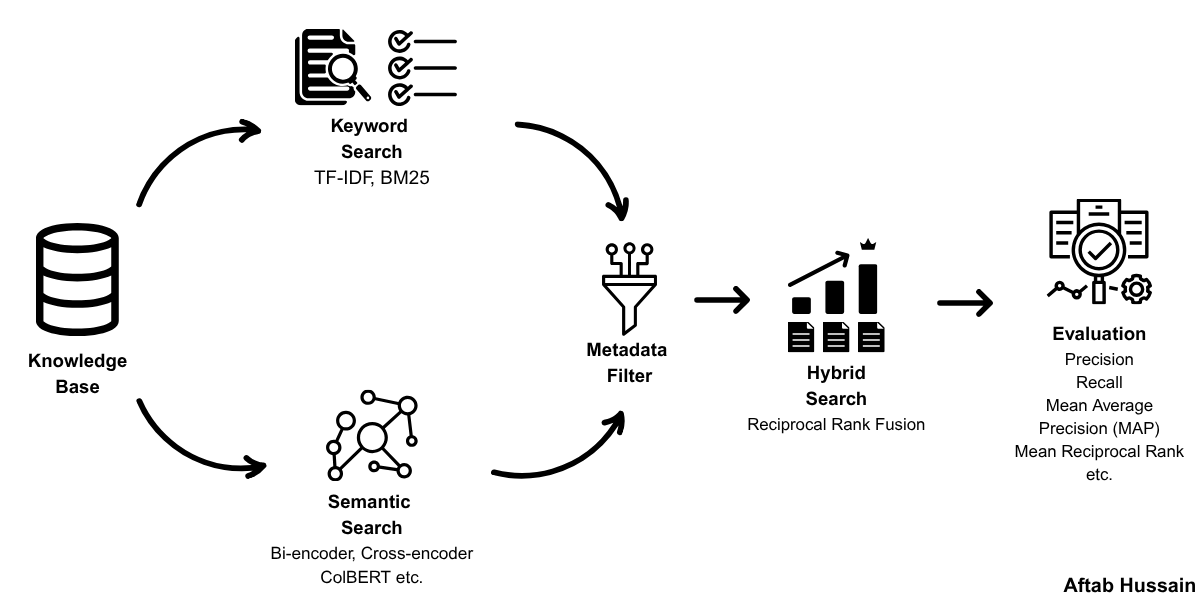

## 🎯 What is Hybrid Search?

**Hybrid Search** combines keyword and semantic search for optimal results. It's like having both a detective (exact clues) and a psychologist (understanding context) working together.

### 🔄 How It Works:
1. **Parallel Processing**: Runs both keyword and semantic search
2. **Score Combination**: Blends results using the `alpha` parameter
3. **Best of Both**: Gets exact matches AND contextually relevant content

### ⚖️ The Alpha Parameter:
- **`alpha = 0.0`**: Pure keyword search (100% sparse)
- **`alpha = 0.5`**: Balanced hybrid (50% keyword + 50% semantic)  
- **`alpha = 1.0`**: Pure semantic search (100% dense)

### ✅ Best For:
- Production RAG systems requiring reliability AND intelligence
- Mixed queries with both specific terms and concepts
- When user search behavior is unpredictable
- Technical domains where exact terms and context both matter

### 🏗️ Implementation:
Uses **LangChain's PineconeHybridSearchRetriever** with **BM25** for keywords and **OpenAI embeddings** for semantics.

🔗 **Learn More**: 
- [Pinecone Hybrid Search](https://docs.pinecone.io/guides/search/hybrid-search)
- [LangChain Integration](https://python.langchain.com/docs/integrations/retrievers/pinecone_hybrid_search/)

In [ ]:
# Implement hybrid search combining keyword + semantic search
from pinecone import Pinecone, ServerlessSpec
from langchain_community.retrievers import PineconeHybridSearchRetriever
from langchain_openai import OpenAIEmbeddings
from pinecone_text.sparse import BM25Encoder
import time, os

# Configuration
INDEX_NAME = "langchain-hybrid-search"
ALPHA = 0.5          # Balance: 0=keyword only, 1=semantic only
TOP_K = 4
BM25_FILE = "bm25_values.json"

# Setup Pinecone index
pc = Pinecone(api_key=os.environ["PINECONE_API_KEY"])

if not pc.has_index(INDEX_NAME):
    pc.create_index(
        name=INDEX_NAME,
        dimension=1536,
        metric="dotproduct",  # Required for hybrid search
        spec=ServerlessSpec(cloud="aws", region="us-east-1")
    )
    print(f"✅ Created hybrid index: {INDEX_NAME}")
else:
    print(f"✅ Using existing hybrid index: {INDEX_NAME}")

index = pc.Index(INDEX_NAME)

# Setup semantic component
emb = OpenAIEmbeddings(model="text-embedding-3-small")

# Setup keyword component (BM25)
try:
    bm25 = BM25Encoder().load(BM25_FILE)
except Exception:
    bm25 = BM25Encoder().default()
    corpus = [str(d.page_content).strip() for d in docs if str(d.page_content).strip()]
    bm25.fit(corpus)
    bm25.dump(BM25_FILE)
    print("✅ BM25 model trained and saved")

# Create hybrid retriever
retriever = PineconeHybridSearchRetriever(
    embeddings=emb,
    sparse_encoder=bm25,
    index=index,
    alpha=ALPHA,
    top_k=TOP_K,
)

# Add documents if index is empty
stats = index.describe_index_stats()
if stats.get("total_vector_count", 0) == 0:
    retriever.add_texts(
        texts=[str(d.page_content) for d in docs],
        metadatas=[d.metadata for d in docs]
    )
    time.sleep(2)
    print("✅ Documents added to hybrid index")

# Test hybrid search
query = "When should I use hybrid search over dense search?"
results = retriever.invoke(query)

print(f"⚡ Hybrid search for: '{query}'")
print(f"Alpha: {ALPHA} (balanced), Found {len(results)} results:")

for i, doc in enumerate(results, start=1):
    md = doc.metadata
    print(f"\nResult {i}:")
    print(f"   ID: {md.get('doc_id', 'N/A')}")
    print(f"   Topic: {md.get('topic', 'N/A')}")
    print(f"   Category: {md.get('category', 'N/A')}")
    print(f"   Content: {doc.page_content[:100]}...")

✅ Index already has 100 vectors.

🔍 Hybrid query (alpha=0.5): When should I use hybrid search over dense search?

✅ Top 6 results:
------------------------------------------------------------
1. id=doc_4 topic=When to Use Hybrid Search in Production category=retrieval diff=intermediate tokens=97.0
In production environments, hybrid search enhances both recall and relevance by merging sparse and dense signals. This technique is especially useful in domains like legal, healthcare, and customer support where accuracy matters. When to Use Hybrid Search in Production is a critical concept when designing advanced search and retrieval systems.
------------------------------------------------------------
2. id=doc_62 topic=When to Use Hybrid Search in Production category=retrieval diff=beginner tokens=149.0
In production environments, hybrid search enhances both recall and relevance by merging sparse and dense signals. This technique is especially useful in domains like legal, healthcare, and 